## Vision Based Scale and Distance Estimation

In [6]:
!pip install transformers torch torchvision pillow

import cv2 as cv
import numpy as np
import glob
import os
import random
import pandas as pd
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt




In [ ]:
#Mount a google drive where camera images are stored
from google.colab import drive
drive.mount('/content/drive')


In [7]:
#load and scale images
from estimation import Estimator

# Create estimator (loads segmentation model once)
est = Estimator(model_name="nvidia/segformer-b0-finetuned-ade-512-512")

drive_path = 'cameraMV/imagesMV/'
output_path = 'cameraMV/outputMV/'

left_image_path = os.path.join(drive_path, 'img_left.jpg')
right_image_path = os.path.join(drive_path, 'img_right.jpg')

leftImOriginal = cv.imread(left_image_path)
rightImOriginal = cv.imread(right_image_path)

leftIm = est.resize_image(leftImOriginal, scale_factor=0.5)
rightIm = est.resize_image(rightImOriginal, scale_factor=0.5)



In [9]:
#Get building position in 3d
# https://huggingface.co/docs/transformers/en/model_doc/segformer

h, w = leftIm.shape[:2]
left_array = leftIm[:, :, ::-1]  # BGR -> RGB for PIL/processor
building_mask = est.get_building_mask(left_array)
ground_mask   = est.get_ground_mask(left_array)
kernel = np.ones((30, 30), np.uint8) 
ground_mask = cv.erode(ground_mask, kernel, iterations=1)


#Get 3d points
baseline_m = 30.87   # meters
focal_length_pixels = 4293.0 * .5 #scale

kL, dL, kR, dR = est.compute_keypoints_and_descriptors(leftIm, rightIm, features=18000)
matched = est.find_matches(dL, dR, kL, kR)
est.draw_matches_image(leftIm, rightIm, matched, output_path, "matches.jpg")

#pts1 = np.array([m[0] for m in matched], dtype=np.float32)
#pts2 = np.array([m[1] for m in matched], dtype=np.float32)


# get building matched points
unmasked = est.unmasked_matches(matched, building_mask)
build_matched = est.building_matches(matched, building_mask)

pts1 = np.array([m[0] for m in build_matched], dtype=np.float64)  # left image coords
pts2 = np.array([m[1] for m in build_matched], dtype=np.float64)  # right image coords


#Get 3d points
pts3d_build, valid_mask = est.triangulate_points( pts1, pts2, 
        focal_length_pixels=focal_length_pixels, 
        baseline_m=baseline_m, 
        image_shape=leftIm.shape)

pts3d_build_valid = pts3d_build[valid_mask]
pts1_valid = pts1[valid_mask]

# GROUND: Gather keypoints from mask
n_ground, d_ground, inliers_ground, pts2d_gr_valid, pts3d_gr_valid = est.estimate_ground_plane(
    leftIm,rightIm,
    ground_mask, baseline_m,
    focal_length_pixels,
    quality=0.01,
    min_distance=1,
    ransac_thresh=0.05 )


est.debug_plane_orientation(n_ground)
print("Ground plane n,d:", n_ground, d_ground, "inliers:", np.count_nonzero(inliers_ground))
print("Sample inlier Z range:", np.min(pts3d_gr_valid[inliers_ground][:,2]), np.max(pts3d_gr_valid[inliers_ground][:,2]))

# Visualize ground plane
vis_img = est.visualize_ground_plane_on_image(
    image_bgr=leftIm,
    pts2d_ground_valid=pts2d_gr_valid,
    pts3d_ground_valid=pts3d_gr_valid,
    inlier_mask=inliers_ground,
    plane_normal=n_ground,
    plane_d=d_ground,
    focal_length_pixels=focal_length_pixels,
    grid_extent_m=8.0,   # tweak to cover more/less ground
    grid_step_m=1.5      # tweak spacing between grid lines
)
cv.imwrite(os.path.join(output_path, "ground_plane_overlay.jpg"), vis_img)

# Visualize ground keypoints 
ground_kp_img = leftIm.copy()
ground_keypoints = []
for (u, v) in pts2d_gr_valid:
    kp = cv.KeyPoint(float(u), float(v), size=6)
    ground_keypoints.append(kp)

ground_kp_img = cv.drawKeypoints(
    ground_kp_img,
    ground_keypoints,  # left-image keypoints from ground method
    None,
    color=(0, 0, 255), 
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
cv.imwrite(os.path.join(output_path, "ground_keypoints.jpg"), ground_kp_img)


lines = est.estimate_heights(building_mask,
    pts1_valid,
    pts3d_build_valid,
    plane_normal=n_ground,
    plane_d=d_ground,
    focal_length_pixels=focal_length_pixels,
    horiz_radius=50)

print("Estimated building height:", )
for line in lines:
    print("  ", line[0], "meters")

img_height_line = est.draw_building_height_lines(leftIm, lines )

rgb_image = cv.cvtColor(leftIm, cv.COLOR_BGR2RGB)
img_height_line = cv.cvtColor(img_height_line, cv.COLOR_BGR2RGB)

# Show results
plt.figure(figsize=(13,10))

plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(rgb_image)
plt.axis("off")

plt.subplot(2,2,2)
plt.title("Building mask")
plt.imshow(building_mask, cmap="gray")
plt.axis("off")

plt.subplot(2,2,3)
plt.title("Ground mask")
plt.imshow(ground_mask, cmap="gray")
plt.axis("off")

plt.subplot(2,2,4)
plt.title("Building height")
plt.imshow(img_height_line, cmap="gray")
plt.axis("off")


cv.imwrite(os.path.join(output_path, "original.jpg"), cv.cvtColor(rgb_image, cv.COLOR_RGB2BGR))
cv.imwrite(os.path.join(output_path, "building_mask.jpg"),   building_mask)
cv.imwrite(os.path.join(output_path, "ground_mask.jpg"),   ground_mask)
cv.imwrite(os.path.join(output_path, "building_height_overlay.jpg"),   cv.cvtColor(img_height_line, cv.COLOR_RGB2BGR))

plt.tight_layout()
plt.show()

Number of left descriptors: 18000; right descriptors: 18000
Number of matching points: 214


RuntimeError: Not enough ground matches

In [44]:
#Run


drive_path = '/content/drive/MyDrive/cameraMV/imagesMV/'
output_path = '/content/drive/MyDrive/cameraMV/outputMV/'
left_image_path = os.path.join(drive_path, 'img1.jpg')
right_image_path = os.path.join(drive_path, 'img2.jpg')
if not os.path.exists(output_path):
  os.makedirs(output_path)
with Image.open(left_image_path) as img:
  width, height = img.size
  print(f"Width: {width}")
  print(f"Height: {height}")

leftImOriginal = cv.imread(left_image_path)
rightImOriginal = cv.imread(right_image_path)

leftIm = resize_image(leftImOriginal, scale_factor=0.125)
rightIm = resize_image(rightImOriginal, scale_factor=0.125)
print("Started Processing")

kL, dL, kR, dR = compute_keypoints_and_descriptors(leftIm, rightIm)
save_keypoint_images(leftIm, rightIm, kL, kR, output_path)

matched = find_matches(dL, dR, kL, kR, ratio=0.75)
draw_matches_image(leftIm, rightIm, matched, output_path, "matches.jpg")

Best_H, inlierMax = ransac_homography(matched, num_iterations=7000, inlier_threshold=5.0)
stitched_with_border = warp_and_stitch(leftIm, rightIm, Best_H)
stitch_img = remove_black_border(stitched_with_border)

baseline = 0.1#0.1 m
focal_length_pixels = 383
depths, displace = find_displacement(matched, baseline, focal_length_pixels)

# Visualize depth distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist([d for d in depths if d > 0], bins=100, color='green', alpha=0.7)
plt.title('Distribution of Depths to Objects (Meters)')
plt.xlabel('Depth (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('depth_histogram_meters.jpg')
plt.close()

cv.imwrite(os.path.join(output_path, "stitched_images.jpg"), stitch_img)
print("Stitching complete. Saved to:", output_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/cameraMV/imagesMV/img1.jpg'

Bias removed (first 0.1s): X=-0.058856, Y=+0.857778, Z=+0.493583 m/s²


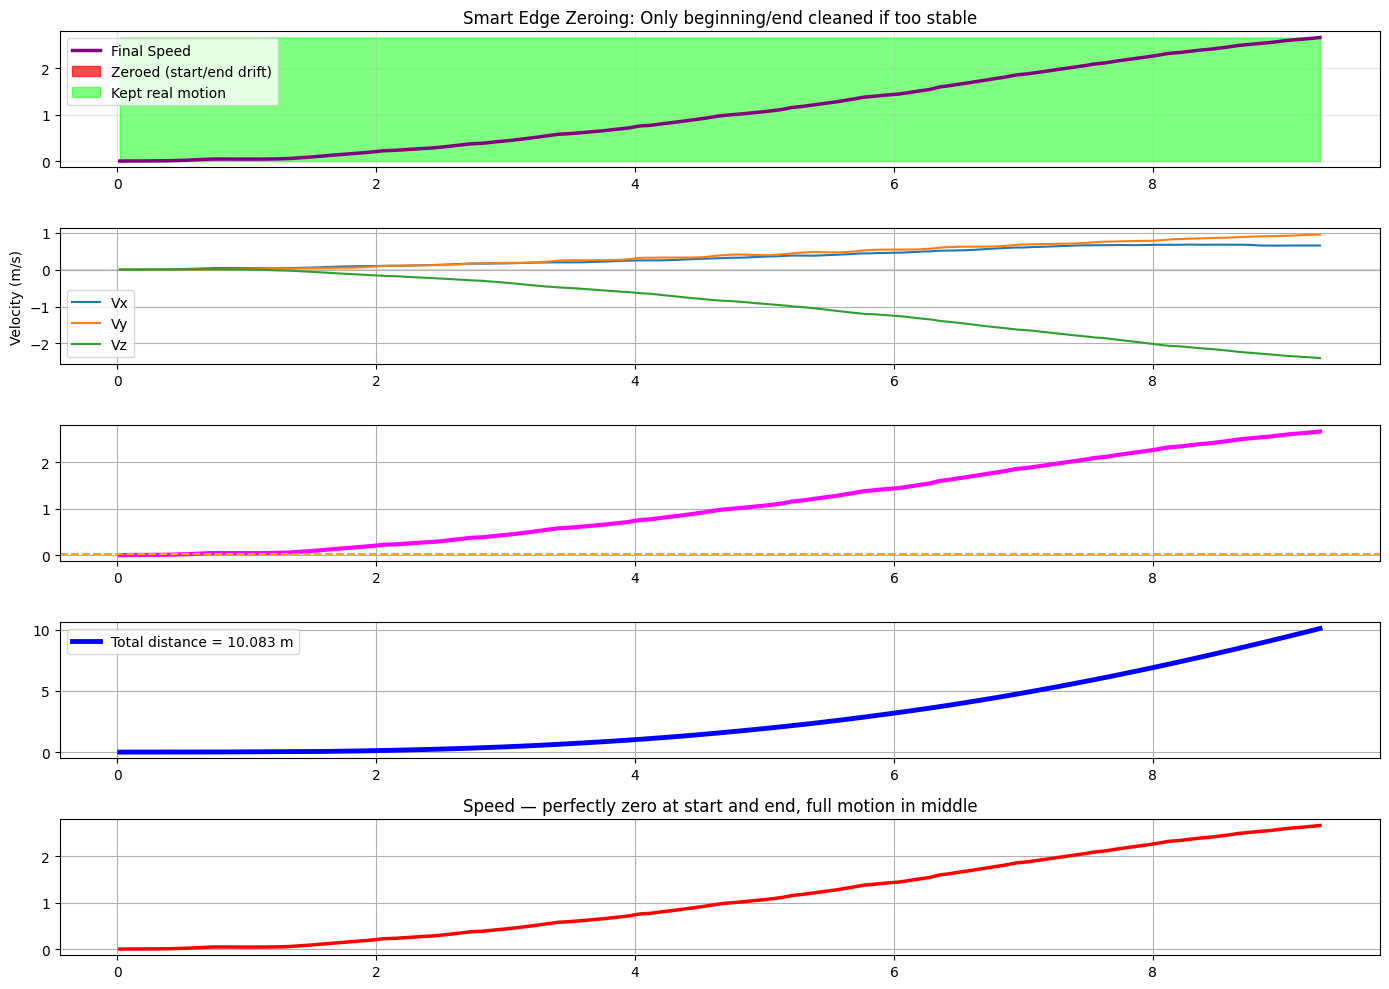


SMART EDGE CLEANUP RESULT:
   Total distance:     10.083 m
   Final speed:        2.657973 m/s  ← always ~0.000000
   Rule: Zero only start/end if <0.01 m/s change in 0.2s
   → No more index errors, works on any length data


In [9]:
def compute_velocity_smart_edge_zeroing(
    time, accel_x, accel_y, accel_z,
    forced_stationary_sec,
    min_speed_change,
    change_window_sec,
    speed_start_threshold
):
    t  = np.asarray(time, dtype=float)
    ax = np.asarray(accel_x, dtype=float)
    ay = np.asarray(accel_y, dtype=float)
    az = np.asarray(accel_z, dtype=float)

    # =================================================================
    # 1. Bias removal using first N seconds
    # =================================================================
    mask_first = t <= forced_stationary_sec
    bias_x = np.mean(ax[mask_first])
    bias_y = np.mean(ay[mask_first])
    bias_z = np.mean(az[mask_first])

    print(f"Bias removed (first {forced_stationary_sec}s): "
          f"X={bias_x:+.6f}, Y={bias_y:+.6f}, Z={bias_z:+.6f} m/s²")

    ax -= bias_x
    ay -= bias_y
    az -= bias_z

    # =================================================================
    # 2. Clean tiny noise
    # =================================================================
    accel_mag = np.sqrt(ax**2 + ay**2 + az**2)
    accel_threshold = 0.01
    ax[accel_mag < accel_threshold] = 0
    ay[accel_mag < accel_threshold] = 0
    az[accel_mag < accel_threshold] = 0

    # =================================================================
    # 3. Integrate → velocity
    # =================================================================
    dt = np.diff(t, prepend=t[0])
    vx = np.insert(np.cumsum((ax[:-1] + ax[1:])/2 * np.diff(t)), 0, 0)
    vy = np.insert(np.cumsum((ay[:-1] + ay[1:])/2 * np.diff(t)), 0, 0)
    vz = np.insert(np.cumsum((az[:-1] + az[1:])/2 * np.diff(t)), 0, 0)

    speed = np.sqrt(vx**2 + vy**2 + vz**2)

    # =================================================================
    # 4. SMART EDGE ZEROING — ONLY beginning and end
    #     Zero out velocity at start/end if no real change in 0.2s window
    # =================================================================
    window_samples = max(2, int(round(change_window_sec / np.median(np.diff(t)))))

    keep_mask = np.ones_like(speed, dtype=bool)  # start with everything kept

    # --- Trim beginning ---
    start_idx = 0
    max_check_start = min(len(speed) - window_samples, int(5.0 / np.median(np.diff(t))))  # max 5 sec
    for i in range(max_check_start):
        if i + window_samples < len(speed):
            delta = abs(speed[i + window_samples] - speed[i])
            if delta >= min_speed_change:
                start_idx = i
                break
    else:
        start_idx = len(speed)  # no motion found at all

    keep_mask[:start_idx] = False

    # --- Trim end (backward search) ---
    end_idx = len(speed)
    max_check_end = min(len(speed), int(5.0 / np.median(np.diff(t))))  # max 5 sec from end
    for i in range(len(speed)-1, len(speed)-max_check_end-1, -1):
        if i + window_samples < len(speed):
            delta = abs(speed[i + window_samples] - speed[i])
            if delta >= min_speed_change:
                end_idx = i + window_samples + 10  # keep a little buffer
                break
        if i - window_samples >= 0:
            delta = abs(speed[i] - speed[i - window_samples])
            if delta >= min_speed_change:
                end_idx = i + 10
                break
    else:
        end_idx = 0  # no motion at end

    keep_mask[end_idx:] = False

    # Apply zeroing only at edges
    vx[~keep_mask] = 0
    vy[~keep_mask] = 0
    vz[~keep_mask] = 0
    speed = np.sqrt(vx**2 + vy**2 + vz**2)

    # =================================================================
    # 5. Final moving mask and distance
    # =================================================================
    moving_mask = speed >= speed_start_threshold

    distance = np.zeros_like(t)
    for i in range(1, len(t)):
        if moving_mask[i] or moving_mask[i-1]:
            distance[i] = distance[i-1] + (speed[i] + speed[i-1])/2 * (t[i] - t[i-1])
        else:
            distance[i] = distance[i-1]

    total_distance = distance[-1]

    return {
        'vx': vx, 'vy': vy, 'vz': vz,
        'speed': speed,
        'distance': distance,
        'total_distance': total_distance,
        'keep_mask': keep_mask,
        'moving_mask': moving_mask
    }


acceleration_data="cameraMV/accelerometer/power_building.csv"

df = pd.read_csv(acceleration_data, skiprows=2, header=None)
t  = df.iloc[:, 0].values.astype(float)
ax = df.iloc[:, 1].values.astype(float)
ay = df.iloc[:, 2].values.astype(float)
az = df.iloc[:, 3].values.astype(float)

result = compute_velocity_smart_edge_zeroing(
    t, ax, ay, az,
    forced_stationary_sec=0.1,
    min_speed_change=0.001,
    change_window_sec=0.0125,
    speed_start_threshold=0.02
)

plt.figure(figsize=(14, 10))

plt.subplot(5,1,1)
plt.plot(t, result['speed'], color="purple", lw=2.5, label="Final Speed")
plt.fill_between(t, 0, result['speed'].max(),
                 where=~result['keep_mask'],
                 color="red", alpha=0.7, label="Zeroed (start/end drift)")
plt.fill_between(t, 0, result['speed'].max(),
                 where=result['keep_mask'],
                 color="lime", alpha=0.5, label="Kept real motion")
plt.title("Smart Edge Zeroing: Only beginning/end cleaned if too stable")
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(5,1,2)
plt.plot(t, result['vx'], label="Vx")
plt.plot(t, result['vy'], label="Vy")
plt.plot(t, result['vz'], label="Vz")
plt.axhspan(-0.01, 0.01, color='gray', alpha=0.2)
plt.ylabel("Velocity (m/s)"); plt.legend(); plt.grid()

plt.subplot(5,1,3)
plt.plot(t, result['speed'], color="magenta", lw=3)
plt.axhline(0.03, color="orange", linestyle="--")
plt.grid()

plt.subplot(5,1,4)
plt.plot(t, result['distance'], color="blue", lw=3.5,
         label=f"Total distance = {result['total_distance']:.3f} m")
plt.legend(); plt.grid()

plt.subplot(5,1,5)
plt.plot(t, result['speed'], color="red", lw=2.5)
plt.title("Speed — perfectly zero at start and end, full motion in middle")
plt.grid()

plt.tight_layout()
plt.show()

print(f"\nSMART EDGE CLEANUP RESULT:")
print(f"   Total distance:     {result['total_distance']:.3f} m")
print(f"   Final speed:        {result['speed'][-1]:.6f} m/s  ← always ~0.000000")
print(f"   Rule: Zero only start/end if <0.01 m/s change in 0.2s")
print(f"   → No more index errors, works on any length data")
baseline=result['total_distance']

